In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/synthetic-data/synthetic_dataset.csv


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(0)

df = pd.read_csv("/kaggle/input/synthetic-data/synthetic_dataset.csv")

X = df.iloc[:, :-1].values          # features
Y_raw = df.iloc[:, -1].values       # class labels (0–4)

Y = np.zeros((len(Y_raw), 5))
Y[np.arange(len(Y_raw)), Y_raw] = 1
X = (X - X.mean(axis=0)) / X.std(axis=0)


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]


In [11]:
class NeuralNetwork(object):
    def __init__(self):
        input_neurons = X.shape[1]   # number of features
        h1 = 16
        h2 = 12
        h3 = 8
        output_neurons = 5           # 5 classes

        self.lr = 0.001

        # Weight initialization
        self.W_H1 = np.random.randn(input_neurons, h1)
        self.W_H2 = np.random.randn(h1, h2)
        self.W_H3 = np.random.randn(h2, h3)
        self.W_O  = np.random.randn(h3, output_neurons)

    def sigmoid(self, x, der=False):
        s = 1 / (1 + np.exp(-x))
        if der:
            return s * (1 - s)
        return s

    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / e.sum(axis=1, keepdims=True)

  
    def feedForward(self, X):
        self.z1 = np.dot(X, self.W_H1)
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W_H2)
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W_H3)
        self.a3 = self.sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W_O)
        self.output = self.softmax(self.z4)

        return self.output


    def backPropagation(self, X, Y, pred):
        # Output layer error (softmax + cross-entropy)
        error_out = pred - Y
        dW_O = np.dot(self.a3.T, error_out)

        # 3rd hidden layer
        error_3 = np.dot(error_out, self.W_O.T) * self.sigmoid(self.a3, der=True)
        dW_H3 = np.dot(self.a2.T, error_3)

        # 2nd hidden layer
        error_2 = np.dot(error_3, self.W_H3.T) * self.sigmoid(self.a2, der=True)
        dW_H2 = np.dot(self.a1.T, error_2)

        # 1st hidden layer
        error_1 = np.dot(error_2, self.W_H2.T) * self.sigmoid(self.a1, der=True)
        dW_H1 = np.dot(X.T, error_1)

        # Update weights
        self.W_O  -= self.lr * dW_O
        self.W_H3 -= self.lr * dW_H3
        self.W_H2 -= self.lr * dW_H2
        self.W_H1 -= self.lr * dW_H1
    # Train
    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)
        return pred


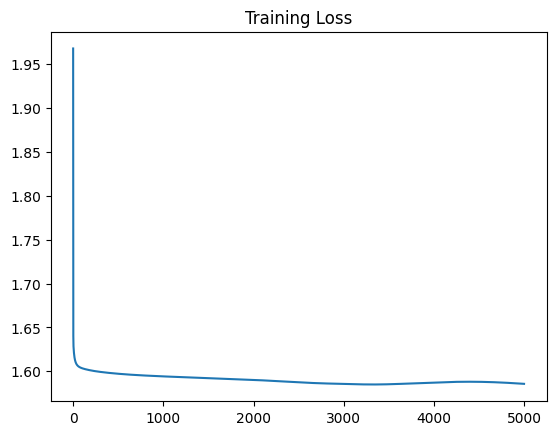

In [12]:
NN = NeuralNetwork()
errors = []

epochs =5000
for i in range(epochs):
    pred = NN.train(X_train, Y_train)
    loss = -np.mean(np.log(pred[Y_train == 1]))
    errors.append(loss)

plt.plot(errors)
plt.title("Training Loss")
plt.show()


In [13]:
# Predictions
test_pred = NN.feedForward(X_test)
y_pred = np.argmax(test_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.215


In [14]:
for cls in range(5):
    TP = np.sum((y_pred == cls) & (y_true == cls))
    FP = np.sum((y_pred == cls) & (y_true != cls))
    FN = np.sum((y_pred != cls) & (y_true == cls))

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    print(f"Class {cls}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


Class 0: Precision=0.226, Recall=0.506, F1=0.312
Class 1: Precision=0.173, Recall=0.257, F1=0.207
Class 2: Precision=0.290, Recall=0.101, F1=0.150
Class 3: Precision=0.227, Recall=0.133, F1=0.168
Class 4: Precision=0.205, Recall=0.103, F1=0.137


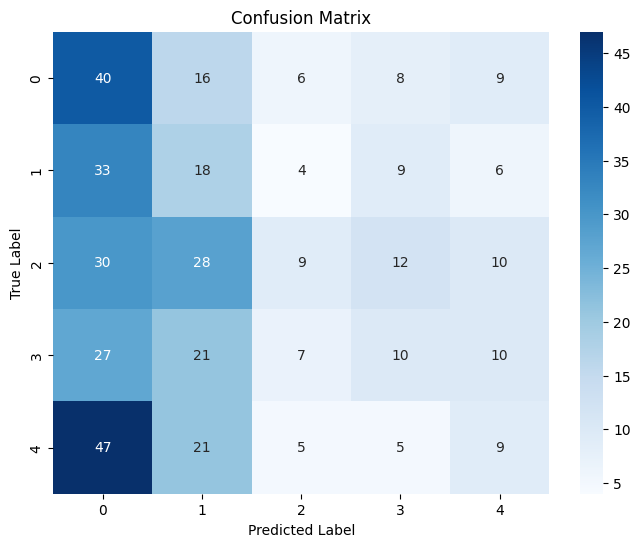

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0, 1, 2, 3, 4], 
            yticklabels=[0, 1, 2, 3, 4])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()